## Классические алгоритмы без ансамблирования
В этом ноутбуке вам нужно обучить модели на датасете классификации из предыдущего ноутбука и сравнить результаты. Вам будет предоставлен baseline, на основе которого вы будете доделывать предсказывающие модели. Оценка лабы будет зависеть от ROC-AUC на тестовых данных по следующим критериям:
\
AUC - на тестовых данных
- $AUC \leq 0.75$ - 0 баллов
- $0.75 < AUC \leq 0.76$ - 2 балла
- $0.76 < AUC \leq 0.77$ - 4 балла
- $0.77 < AUC \leq 0.78$ - 6 баллов
- $0.78 < AUC \leq 0.79$ - 8 баллов
- $AUC > 0.79$ - 10 баллов

\
В этой работе запрещено использовать ансамбли моделей (лес, бустинги и т.д.)!

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, accuracy_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [20]:
data = pd.read_csv('german.csv', sep=';')
print(data.head())

X = data.iloc[:, 1:]
X = X.drop('Foreign_Worker', axis=1)
y = data.iloc[:, 0].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

   Creditability  Account_Balance  Duration_of_Credit_monthly  \
0              1                1                          18   
1              1                1                           9   
2              1                2                          12   
3              1                1                          12   
4              1                1                          12   

   Payment_Status_of_Previous_Credit  Purpose  Credit_Amount  \
0                                  4        2           1049   
1                                  4        0           2799   
2                                  2        9            841   
3                                  4        0           2122   
4                                  4        0           2171   

   Value_Savings_Stocks  Length_of_current_employment  Instalment_per_cent  \
0                     1                             2                    4   
1                     1                             3               

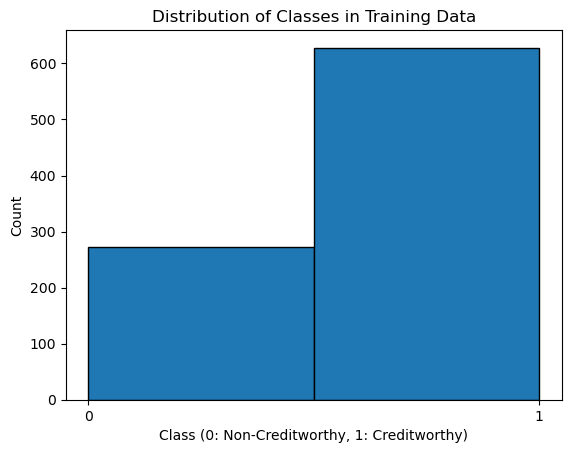

In [3]:
plt.hist(y_train, bins=2, edgecolor='k')
plt.xticks([0, 1])
plt.xlabel('Class (0: Non-Creditworthy, 1: Creditworthy)')
plt.ylabel('Count')
plt.title('Distribution of Classes in Training Data')
plt.show()

# Ход эксперемента с моделями

При использовании моделей с параметрами, по умолчанию встроенными в sklearn, результаты оказались следующими:
- ROC AUC of Logistic Regression: 0.7798036465638148
- ROC AUC of Decision Tree: 0.6832632071061243
- ROC AUC of K-Nearest Neighbors: 0.5781907433380085

Работа с логистической регрессией:
1) при установке 100 итераций (эпох):
- ROC AUC of Logistic Regression: 0.7798036465638148
2) при установке 1000 итераций получили значение ROC-AUC > 0.79:
- ROC AUC of Logistic Regression: 0.793010752688172
3) вылезало предупреждение о том что логистическая регрессия не успевает сойтись, поставил 5000 итераций, ROC-AUC ещё увеличился:
- ROC AUC of Logistic Regression: 0.8313492063492064

Работа с деревом решений:
1) ручной перебор не дал необходимых результатов, поэтому прописал в коде автоматический перебор лучших гиперпараметров глубины дерева и кол-ва рассматриваемых признаков для разделения. Получился следующий результат:
- ROC AUC of Decision Tree: 0.7386044880785413
2) исколючил из датасета признак Foreign_Worker, ведь в файле "Линнейная модель и градиентный спуск" было указано, что его можно исключить. ROC-AUC увеличился:
- ROC AUC of Decision Tree: 0.755142589995325
3) дал модели больше данных для обучения - 9/10 всех данных, для тестов оставил 1/10 всех данных. Получили значение ROC-AUC > 0.79:
- ROC AUC of Decision Tree: 0.8065476190476191.

P.S. Из-за изменения датасета для обучения, увеличился ROC-AUC логистической регрессии:
- ROC AUC of Logistic Regression: 0.8382936507936508

Работа с ближайшим количеством соседей:
1) при установке 5 соседей:
- ROC AUC of K-Nearest Neighbors: 0.535218253968254
2) при установке 100 соседей ROC-AUC увеличился:
- ROC AUC of K-Nearest Neighbors: 0.6436011904761905
3) При установке расстояния 0.1 для метрики Минковского:
- ROC AUC of K-Nearest Neighbors: 0.785218253968254
4) При установке расстояния 0.2 для метрики Минковского, получили значение ROC-AUC > 0.79 :
- ROC AUC of K-Nearest Neighbors: 0.7929067460317459

In [36]:
logistic_regression_model = LogisticRegression(max_iter=5000)
logistic_regression_model.fit(X_train, y_train)

state = 42
best_depth = (0, 0)
for depth in range(1, 50):
    decision_tree = DecisionTreeClassifier(max_depth=depth, random_state=state)
    decision_tree.fit(X_train, y_train)
    y_proba = decision_tree.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    if auc > best_depth[1]:
        best_depth = (depth, auc)

best_feat = (0, 0)
for feat in ['sqrt', 'log2', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, None]:
    decision_tree = DecisionTreeClassifier(max_depth=best_depth[0], max_features=feat, random_state=state)
    decision_tree.fit(X_train, y_train)
    y_proba = decision_tree.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    if auc > best_feat[1]:
        best_feat = (feat, auc)

decision_tree_model = DecisionTreeClassifier(max_depth=best_depth[0], max_features=best_feat[0], random_state=state)
decision_tree_model.fit(X_train, y_train)

knn_model = KNeighborsClassifier(n_neighbors=100, p = 0.2)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=100, p=0.2)

In [37]:
y_prob_logistic = logistic_regression_model.predict_proba(X_test)[:, 1]
y_prob_decision_tree = decision_tree_model.predict_proba(X_test)[:, 1]
y_prob_knn = knn_model.predict_proba(X_test)[:, 1]

y_pred_logistic = logistic_regression_model.predict(X_test)
y_pred_decision_tree = decision_tree_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)

accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

roc_auc_logistic = roc_auc_score(y_test, y_prob_logistic)
roc_auc_decision_tree = roc_auc_score(y_test, y_prob_decision_tree)
roc_auc_knn = roc_auc_score(y_test, y_prob_knn)

precision_logistic = precision_score(y_test, y_pred_logistic)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree)
precision_knn = precision_score(y_test, y_pred_knn)

recall_logistic = recall_score(y_test, y_pred_logistic)
recall_decision_tree = recall_score(y_test, y_pred_decision_tree)
recall_knn = recall_score(y_test, y_pred_knn)

print(f'Accuracy of Logistic Regression: {accuracy_logistic}')
print(f'Accuracy of Decision Tree: {accuracy_decision_tree}')
print(f'Accuracy of K-Nearest Neighbors: {accuracy_knn}')

print(f'ROC AUC of Logistic Regression: {roc_auc_logistic}')
print(f'ROC AUC of Decision Tree: {roc_auc_decision_tree}')
print(f'ROC AUC of K-Nearest Neighbors: {roc_auc_knn}')

print(f'Precision of Logistic Regression: {precision_logistic}')
print(f'Precision of Decision Tree: {precision_decision_tree}')
print(f'Precision of K-Nearest Neighbors: {precision_knn}')

print(f'Recall of Logistic Regression: {recall_logistic}')
print(f'Recall of Decision Tree: {recall_decision_tree}')
print(f'Recall of K-Nearest Neighbors: {recall_knn}')

Accuracy of Logistic Regression: 0.78
Accuracy of Decision Tree: 0.72
Accuracy of K-Nearest Neighbors: 0.73
ROC AUC of Logistic Regression: 0.8313492063492064
ROC AUC of Decision Tree: 0.8065476190476191
ROC AUC of K-Nearest Neighbors: 0.7929067460317459
Precision of Logistic Regression: 0.8048780487804879
Precision of Decision Tree: 0.72
Precision of K-Nearest Neighbors: 0.7272727272727273
Recall of Logistic Regression: 0.9166666666666666
Recall of Decision Tree: 1.0
Recall of K-Nearest Neighbors: 1.0


## Экспериментируйте
Для получения лучшего качества придется поэкспериментировать. Подсказка: попробуйте оптимизировать гиперпараметры модели